# Import Libraries

In [530]:
import unittest.mock

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

## Data Correction

In [531]:
df = pd.read_csv("orders.csv")

df['DateTime'] = pd.to_datetime(df['DateTime_CartFinalize'])
df['Quantity_item'] = df['Quantity_item'].astype(np.int64)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 8 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   ID_Order               200000 non-null  int64         
 1   ID_Customer            200000 non-null  int64         
 2   ID_Item                200000 non-null  int64         
 3   DateTime_CartFinalize  200000 non-null  object        
 4   Amount_Gross_Order     200000 non-null  float64       
 5   city_name_fa           200000 non-null  object        
 6   Quantity_item          200000 non-null  int64         
 7   DateTime               200000 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(4), object(2)
memory usage: 12.2+ MB


In [532]:
df.columns

Index(['ID_Order', 'ID_Customer', 'ID_Item', 'DateTime_CartFinalize',
       'Amount_Gross_Order', 'city_name_fa', 'Quantity_item', 'DateTime'],
      dtype='object')

### تعداد فروش کلی به ازای هرروز

In [533]:
daily_sales = df.groupby(df['DateTime'].dt.date)['Quantity_item'].sum().reset_index()
daily_sales.columns = ['DateTime' , 'Total_Quantity_item']
daily_sales

,DateTime,Total_Quantity_item
0,2013-09-27,3
1,2013-09-28,2
2,2013-09-29,1
3,2013-09-30,1
4,2013-10-04,4
...,...,...
1885,2018-12-07,242
1886,2018-12-08,289
1887,2018-12-09,323
1888,2018-12-10,307


### تعداد فروش به ازای هر شهر

In [534]:

sales_by_city_date = df.groupby([df['DateTime'].dt.date, 'city_name_fa'])['Quantity_item'].sum().reset_index()
sales_by_city_date

,DateTime,city_name_fa,Quantity_item
0,2013-09-27,تهران,1
1,2013-09-27,شهرکرد,1
2,2013-09-27,قم,1
3,2013-09-28,زنجان,2
4,2013-09-29,رشت,1
...,...,...,...
56307,2018-12-11,شیراز,2
56308,2018-12-11,قزوین,1
56309,2018-12-11,قم,7
56310,2018-12-11,کامیاران,1


In [535]:
daily_sales['DateTime'] = pd.to_datetime(daily_sales['DateTime'])
daily_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1890 entries, 0 to 1889
Data columns (total 2 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   DateTime             1890 non-null   datetime64[ns]
 1   Total_Quantity_item  1890 non-null   int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 29.7 KB


In [536]:
daily_sales.to_csv("Daily_Sales_Quantity_Date.csv", index=False)

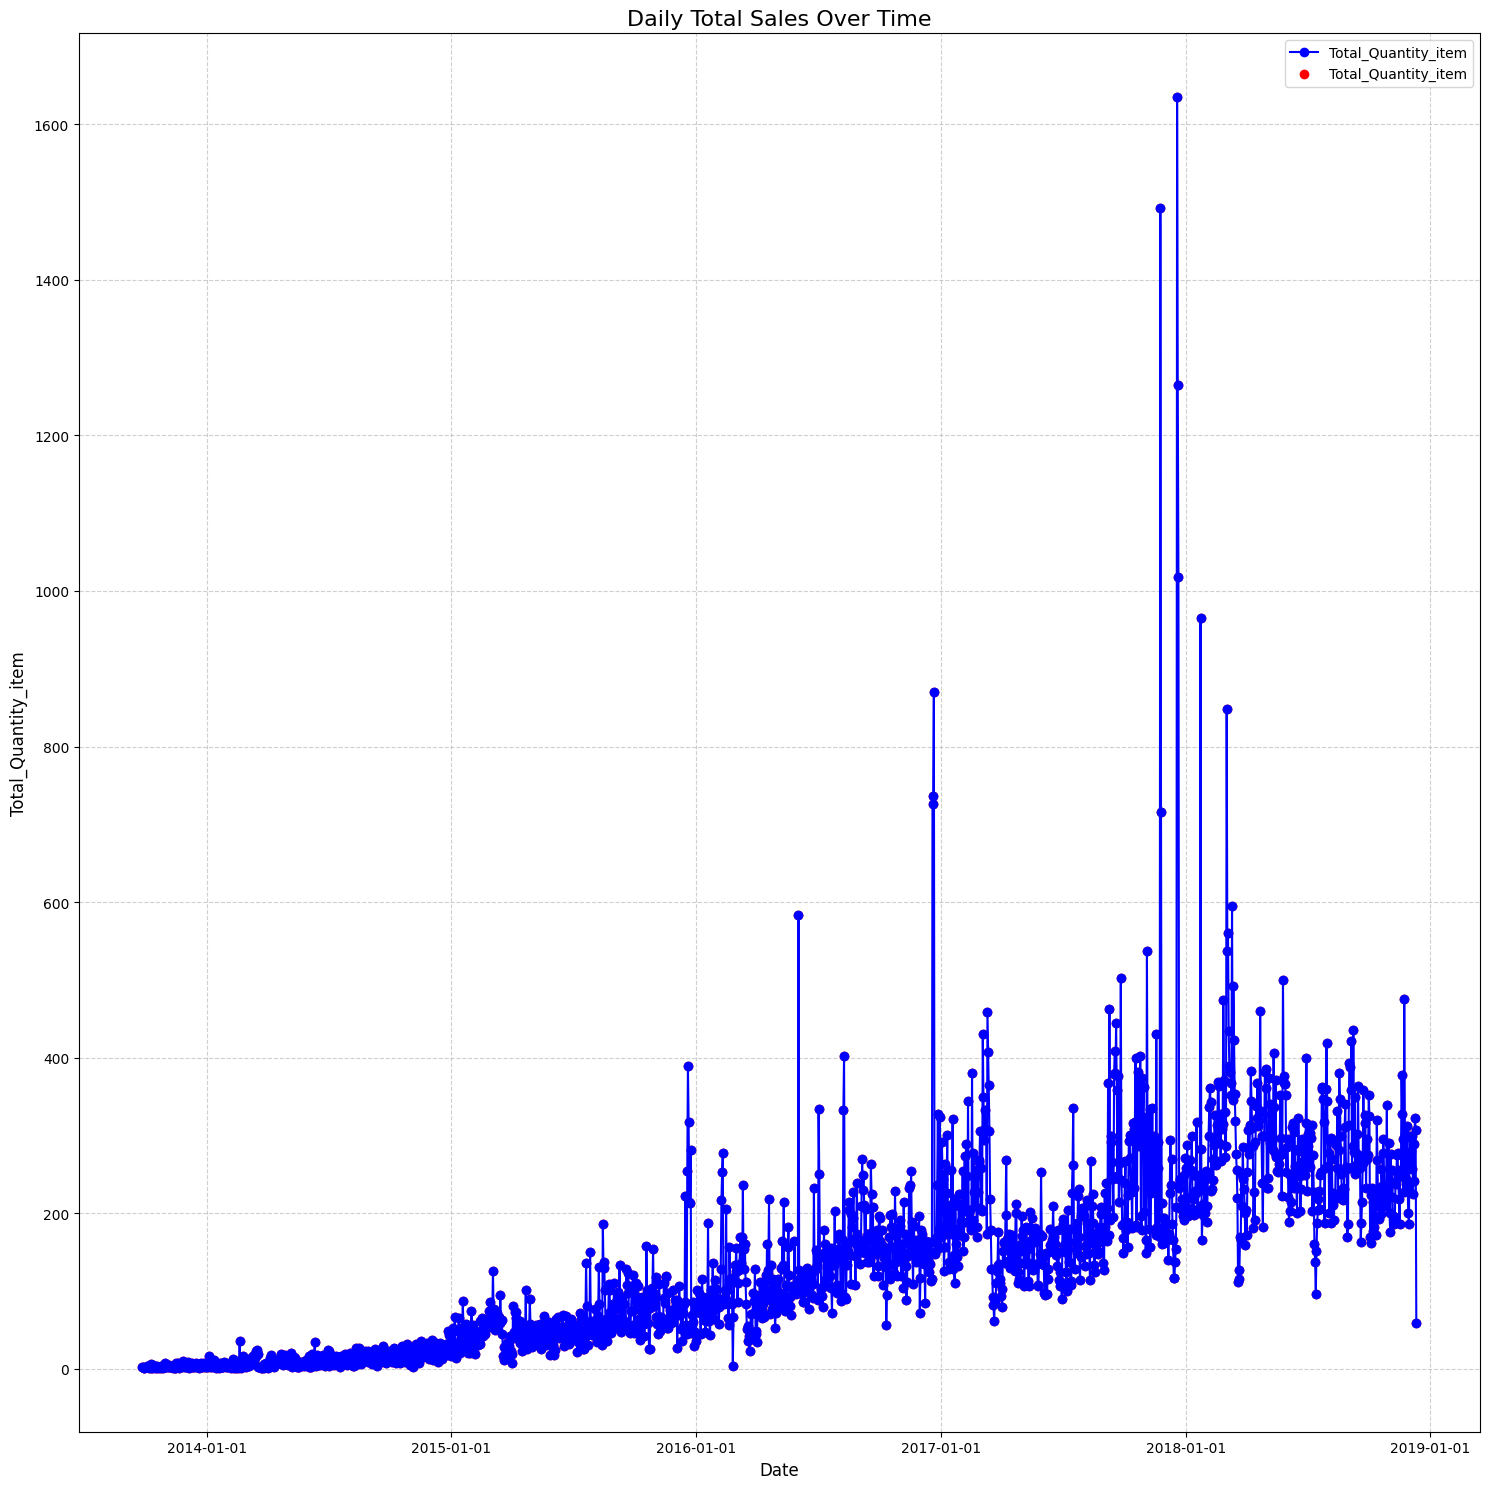

In [537]:
plt.figure(figsize=(15, 15))

plt.plot(daily_sales['DateTime'], daily_sales['Total_Quantity_item'], label='Total_Quantity_item', color='blue', marker='o', linestyle='-')
plt.scatter(daily_sales['DateTime'], daily_sales['Total_Quantity_item'], label='Total_Quantity_item', color='red', marker='o',)

plt.title('Daily Total Sales Over Time', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Total_Quantity_item', fontsize=12)

ax = plt.gca()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d')) # فرمت تاریخ: سال-ماه-روز
ax.xaxis.set_major_locator(mdates.AutoDateLocator())


plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()

plt.show()

In [538]:
daily_sales.describe()

,DateTime,Total_Quantity_item
count,1890,1890.000000
mean,2016-05-10 01:58:51.428571392,133.462963
min,2013-09-27 00:00:00,1.000000
25%,2015-01-24 06:00:00,29.000000
50%,2016-05-10 12:00:00,108.500000
75%,2017-08-25 18:00:00,203.000000
max,2018-12-11 00:00:00,1635.000000
std,NaN,129.593243


### Ouliers Detection

#### IQR (Interquartile Range)

In [539]:
Q1 = np.quantile(daily_sales['Total_Quantity_item'], 0.25)
Q2 = np.quantile(daily_sales['Total_Quantity_item'], 0.50)
Q3 = np.quantile(daily_sales['Total_Quantity_item'], 0.75)


In [540]:
total_quantity = daily_sales["Total_Quantity_item"].values

In [541]:
total_quantity[total_quantity < Q1].size

466

In [542]:
total_quantity[(total_quantity >= Q1) & (total_quantity < Q2)].size

479

In [543]:
total_quantity[(total_quantity >= Q2) & (total_quantity < Q3)].size

468

In [544]:
total_quantity[total_quantity >= Q3].size

477

In [545]:
IQR = Q3 - Q1
upper_bound = Q3 + 1.5 * IQR
lower_bound = Q1 - 1.5 * IQR
lower_bond = 0 # Lower Bound can not be a negative number

In [546]:
outliers_low = daily_sales[total_quantity < lower_bound]
outliers_high = daily_sales[total_quantity > upper_bound]
outliers_high.value_counts().sum()

np.int64(20)

In [547]:
daily_sales["DateTime"].value_counts().sum()

np.int64(1890)

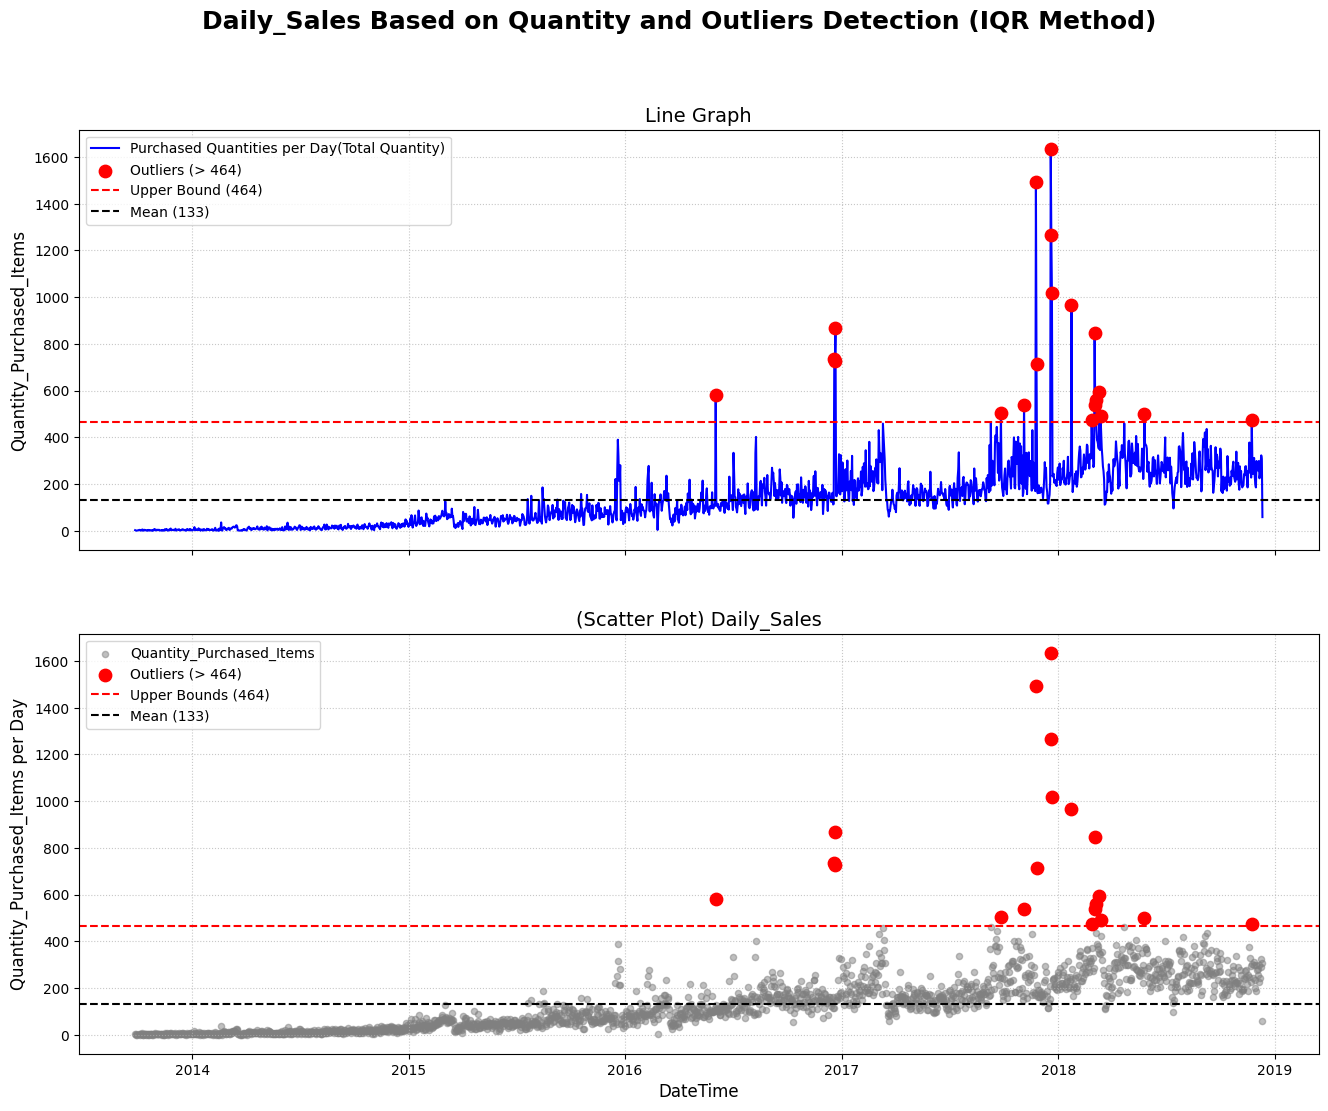

In [548]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(16, 12), sharex=True)
fig.suptitle('Daily_Sales Based on Quantity and Outliers Detection (IQR Method)', fontsize=18, fontweight='bold')


axes[0].plot(daily_sales['DateTime'], daily_sales['Total_Quantity_item'], label='Purchased Quantities per Day(Total Quantity)', color='blue', linewidth=1.5)
axes[0].scatter(outliers_high['DateTime'], outliers_high['Total_Quantity_item'],
                color='red', label=f'Outliers (> {upper_bound:.0f})', s=80, zorder=5)

axes[0].axhline(upper_bound, color='red', linestyle='--', linewidth=1.5, label=f'Upper Bound ({upper_bound:.0f})')
axes[0].axhline(total_quantity.mean() , color='black', linestyle='--', linewidth=1.5, label=f'Mean ({total_quantity.mean():.0f})')

axes[0].set_title('Line Graph', fontsize=14)
axes[0].set_ylabel('Quantity_Purchased_Items', fontsize=12)

axes[0].legend(loc='upper left')
axes[0].grid(True, linestyle=':', alpha=0.7)


axes[1].scatter(daily_sales['DateTime'], daily_sales['Total_Quantity_item'], label='Quantity_Purchased_Items', color='gray', alpha=0.5, s=20)
axes[1].scatter(outliers_high['DateTime'], outliers_high['Total_Quantity_item'],
                color='red', label=f'Outliers (> {upper_bound:.0f})', s=80, zorder=5)

axes[1].axhline(upper_bound, color='red', linestyle='--', linewidth=1.5, label=f'Upper Bounds ({upper_bound:.0f})')
axes[1].axhline(total_quantity.mean() , color='black', linestyle='--', linewidth=1.5, label=f'Mean ({total_quantity.mean():.0f})')

axes[1].set_title('(Scatter Plot) Daily_Sales', fontsize=14)

axes[1].set_xlabel('DateTime', fontsize=12)
axes[1].set_ylabel('Quantity_Purchased_Items per Day', fontsize=12)

axes[1].legend(loc='upper left')
axes[1].grid(True, linestyle=':', alpha=0.7)


#### Outliers Based On the Date (IQR-Based) (Total 20)

In [549]:
outliers_high['DateTime']

967    2016-06-02
1167   2016-12-19
1168   2016-12-20
1169   2016-12-21
1448   2017-09-26
1487   2017-11-04
1507   2017-11-24
1508   2017-11-25
1532   2017-12-19
1533   2017-12-20
1534   2017-12-21
1567   2018-01-23
1601   2018-02-26
1606   2018-03-03
1607   2018-03-04
1608   2018-03-05
1614   2018-03-11
1616   2018-03-13
1690   2018-05-26
1871   2018-11-23
Name: DateTime, dtype: datetime64[ns]

##### Total Ouliers Based On Date

In [550]:
sorted_outliers = outliers_high.sort_values(by='Total_Quantity_item', ascending=False)
sorted_outliers

,DateTime,Total_Quantity_item
1532,2017-12-19,1635
1507,2017-11-24,1492
1533,2017-12-20,1265
1534,2017-12-21,1018
1567,2018-01-23,965
1169,2016-12-21,870
1606,2018-03-03,848
1167,2016-12-19,737
1168,2016-12-20,726
1508,2017-11-25,716


##### 5 Days with the most Excessive Outliers

In [551]:
sorted_outliers['DateTime'].head(5)

1532   2017-12-19
1507   2017-11-24
1533   2017-12-20
1534   2017-12-21
1567   2018-01-23
Name: DateTime, dtype: datetime64[ns]

##### 5 months with the Lightest Outliers


In [552]:
sorted_outliers['DateTime'].tail(5)

1448   2017-09-26
1690   2018-05-26
1616   2018-03-13
1871   2018-11-23
1601   2018-02-26
Name: DateTime, dtype: datetime64[ns]

#### Mean +_ std

In [553]:
mean = total_quantity.mean()
std = total_quantity.std()

upper_bound = mean + 3 * std
lower_bound = mean - 3 * std
lower_bond = 0 # Quantity != -num

In [554]:
outliers_low = daily_sales[total_quantity < lower_bound]
outliers_high = daily_sales[total_quantity > upper_bound]
outliers_high.value_counts().sum()

np.int64(15)

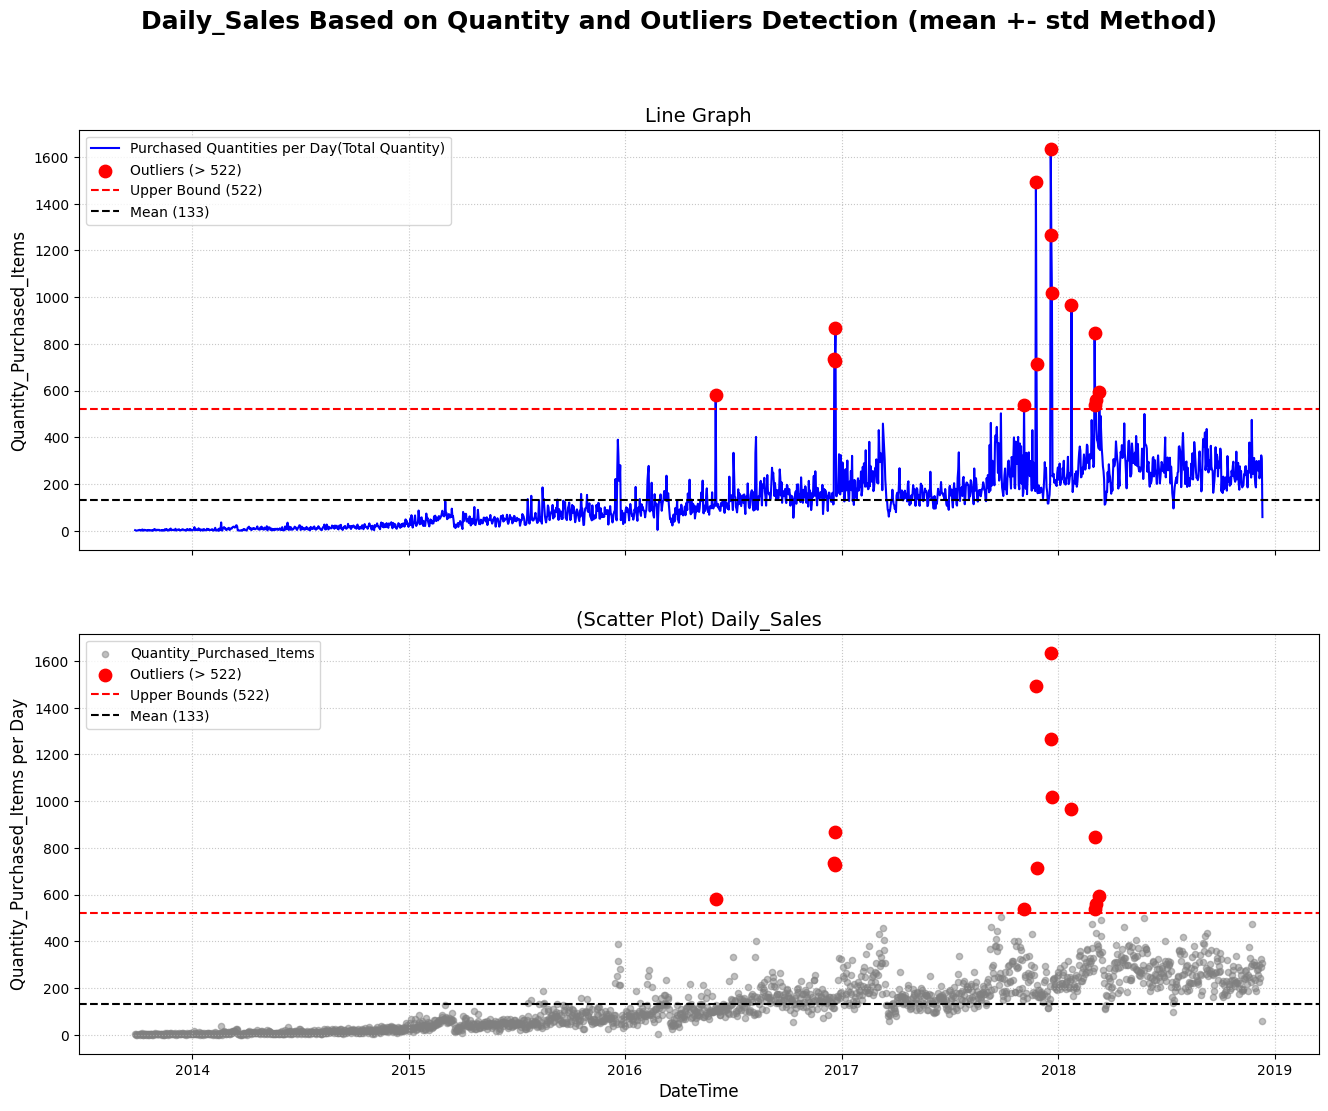

In [555]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(16, 12), sharex=True)

fig.suptitle('Daily_Sales Based on Quantity and Outliers Detection (mean +- std Method)', fontsize=18, fontweight='bold')

axes[0].plot(daily_sales['DateTime'], daily_sales['Total_Quantity_item'], label='Purchased Quantities per Day(Total Quantity)', color='blue', linewidth=1.5)
axes[0].scatter(outliers_high['DateTime'], outliers_high['Total_Quantity_item'],
                color='red', label=f'Outliers (> {upper_bound:.0f})', s=80, zorder=5)

axes[0].axhline(upper_bound, color='red', linestyle='--', linewidth=1.5, label=f'Upper Bound ({upper_bound:.0f})')
axes[0].axhline(mean , color='black', linestyle='--', linewidth=1.5, label=f'Mean ({mean:.0f})')

axes[0].set_title('Line Graph', fontsize=14)

axes[0].set_ylabel('Quantity_Purchased_Items', fontsize=12)

axes[0].legend(loc='upper left')
axes[0].grid(True, linestyle=':', alpha=0.7)


axes[1].scatter(daily_sales['DateTime'], daily_sales['Total_Quantity_item'], label='Quantity_Purchased_Items', color='gray', alpha=0.5, s=20)
axes[1].scatter(outliers_high['DateTime'], outliers_high['Total_Quantity_item'],
                color='red', label=f'Outliers (> {upper_bound:.0f})', s=80, zorder=5)

axes[1].axhline(upper_bound, color='red', linestyle='--', linewidth=1.5, label=f'Upper Bounds ({upper_bound:.0f})')
axes[1].axhline(mean , color='black', linestyle='--', linewidth=1.5, label=f'Mean ({mean:.0f})')

axes[1].set_title('(Scatter Plot) Daily_Sales', fontsize=14)

axes[1].set_xlabel('DateTime', fontsize=12)
axes[1].set_ylabel('Quantity_Purchased_Items per Day', fontsize=12)

axes[1].legend(loc='upper left')
axes[1].grid(True, linestyle=':', alpha=0.7)


#### Outliers Based On the Date (mean+-std)

##### Total Outliers Based on Date (Total 15)

In [556]:
outliers_high['DateTime']

967    2016-06-02
1167   2016-12-19
1168   2016-12-20
1169   2016-12-21
1487   2017-11-04
1507   2017-11-24
1508   2017-11-25
1532   2017-12-19
1533   2017-12-20
1534   2017-12-21
1567   2018-01-23
1606   2018-03-03
1607   2018-03-04
1608   2018-03-05
1614   2018-03-11
Name: DateTime, dtype: datetime64[ns]

In [557]:
sorted_outliers = outliers_high.sort_values(by='Total_Quantity_item', ascending=False)
sorted_outliers

,DateTime,Total_Quantity_item
1532,2017-12-19,1635
1507,2017-11-24,1492
1533,2017-12-20,1265
1534,2017-12-21,1018
1567,2018-01-23,965
1169,2016-12-21,870
1606,2018-03-03,848
1167,2016-12-19,737
1168,2016-12-20,726
1508,2017-11-25,716


##### 5 Days with the most Excessive Outliers

In [558]:
sorted_outliers['DateTime'].head(5)

1532   2017-12-19
1507   2017-11-24
1533   2017-12-20
1534   2017-12-21
1567   2018-01-23
Name: DateTime, dtype: datetime64[ns]

##### 5 Days with the Lightest Outliers

In [559]:
sorted_outliers['DateTime'].tail(5)

1614   2018-03-11
967    2016-06-02
1608   2018-03-05
1487   2017-11-04
1607   2018-03-04
Name: DateTime, dtype: datetime64[ns]

#### Violin and Box Plot

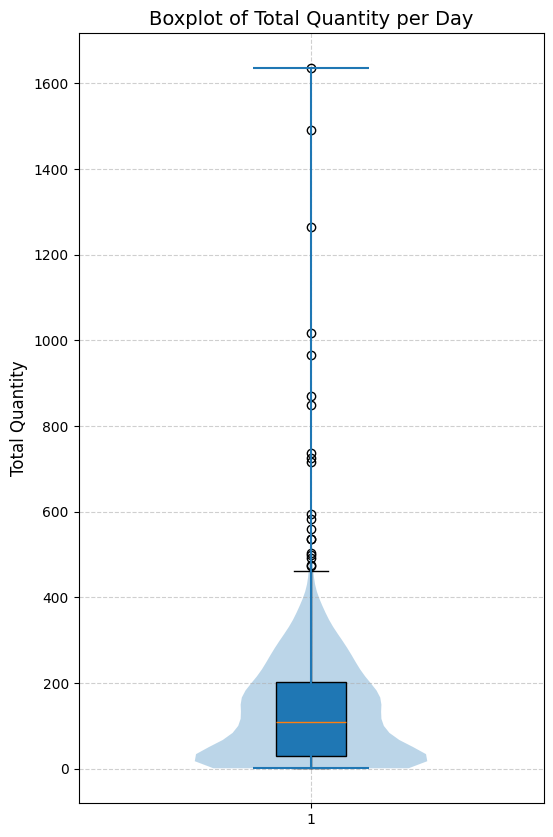

In [560]:
plt.figure(figsize=(6, 10))

plt.boxplot(daily_sales["Total_Quantity_item"], vert=True, patch_artist=True)
plt.violinplot(daily_sales["Total_Quantity_item"], vert=True)

plt.title("Boxplot of Total Quantity per Day", fontsize=14)
plt.ylabel("Total Quantity", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)

